In [98]:
# LIBRARIES AND MODULES REQUIRED FOR THIS MODEL

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings('ignore')

In [11]:
# Loading dataset to be used in project

df = pd.read_csv('kidney_disease.csv')

### Understanding the dataset

In [13]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [15]:
# Dropping 'id' column as it would be an irrelevant feature in model

df.drop('id', axis=1, inplace=True)

In [21]:
# Checking the shape of our Dataset (rows, columns)

df.shape

(400, 25)

In [23]:
# Checking summary of dtaframe of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [25]:
# Handle missing values for numerical columns (float64)
numerical_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Handle missing values for categorical columns (object)
categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.strip().str.lower())
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Convert specific columns to numeric (object to numeric datatype)
cols_to_convert = ['pcv', 'wc', 'rc']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Fill any new NaN values introduced during conversion
df[cols_to_convert] = df[cols_to_convert].fillna(df[cols_to_convert].median())


In [27]:
# Generating descriptive statistics for daataframe

df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000
mean,51.562500,76.575000,1.017712,0.90000,0.395000,145.062500,56.693000,2.997125,137.631250,4.577250,12.54250,39.082500,8298.500000,4.737750
std,16.982996,13.489785,0.005434,1.31313,1.040038,75.260774,49.395258,5.628886,9.206332,2.821357,2.71649,8.162245,2529.593814,0.841439
min,2.000000,50.000000,1.005000,0.00000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.10000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.015000,0.00000,0.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.87500,34.000000,6975.000000,4.500000
50%,55.000000,80.000000,1.020000,0.00000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.65000,40.000000,8000.000000,4.800000
75%,64.000000,80.000000,1.020000,2.00000,0.000000,150.000000,61.750000,2.725000,141.000000,4.800000,14.62500,44.000000,9400.000000,5.100000
max,90.000000,180.000000,1.025000,5.00000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.80000,54.000000,26400.000000,8.000000


In [29]:
# Checking colums with zero's in Dataframe

(df == 0).sum()

age                 0
bp                  0
sg                  0
al                245
su                339
rbc                 0
pc                  0
pcc                 0
ba                  0
bgr                 0
bu                  0
sc                  0
sod                 0
pot                 0
hemo                0
pcv                 0
wc                  0
rc                  0
htn                 0
dm                  0
cad                 0
appet               0
pe                  0
ane                 0
classification      0
dtype: int64

In [31]:
# Defining columns where 0 likely represents missing values ['al' (albumin) and 'su' (sugar) as indicated in our output]
invalid_cols = ['al', 'su']

# Replacing 0 with NaN in these columns
df[invalid_cols] = df[invalid_cols].replace(0, np.nan)

# Checking the number of missing values per column
missing_values_summary = df.isnull().sum()
missing_values_summary


age                 0
bp                  0
sg                  0
al                245
su                339
rbc                 0
pc                  0
pcc                 0
ba                  0
bgr                 0
bu                  0
sc                  0
sod                 0
pot                 0
hemo                0
pcv                 0
wc                  0
rc                  0
htn                 0
dm                  0
cad                 0
appet               0
pe                  0
ane                 0
classification      0
dtype: int64

In [46]:
# Review 'al' and 'su' column in dataframe
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,NaN,normal,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,NaN,normal,normal,notpresent,notpresent,121.0,...,38.0,6000.0,4.8,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,4.8,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,NaN,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,NaN,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [35]:
# Further review

print(df['al'].describe())
print(df['su'].describe())

count    155.000000
mean       2.322581
std        1.068653
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: al, dtype: float64
count    61.000000
mean      2.590164
std       1.188515
min       1.000000
25%       2.000000
50%       2.000000
75%       4.000000
max       5.000000
Name: su, dtype: float64


In [37]:
# Impute missing values in 'al' and 'su' with the median [Median is robust to outliers and better represents the center of skewed data]
df['al'].fillna(df['al'].median(), inplace=True)
df['su'].fillna(df['su'].median(), inplace=True)

# Verify that missing values are resolved
print(df.isnull().sum())

age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64


In [39]:
# Understanding Classification column in dataframe

print(df['classification'].unique())

['ckd' 'ckd\t' 'notckd']


In [41]:
# Clean up the 'classification' column
df['classification'] = df['classification'].str.strip().str.lower()

# Verify the unique values again
print(df['classification'].unique())


['ckd' 'notckd']


### VISUALIZATION

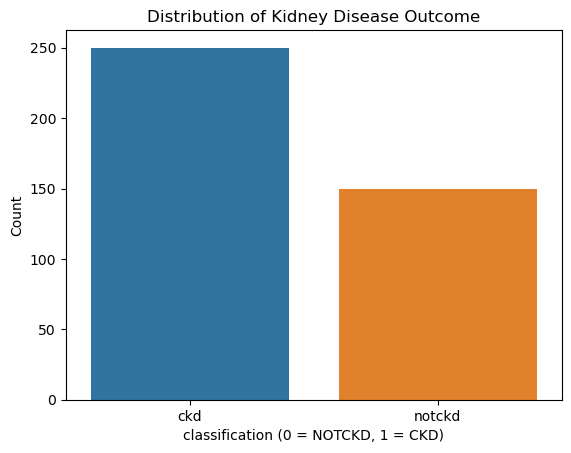

In [44]:
#  Chronic Kidney Disease (CKD) or Not CKD
sns.countplot(x='classification', data=df, hue='classification', dodge=False)
plt.title('Distribution of Kidney Disease Outcome')
plt.xlabel('classification (0 = NOTCKD, 1 = CKD)')
plt.ylabel('Count')
plt.show()

<Figure size 1500x1000 with 0 Axes>

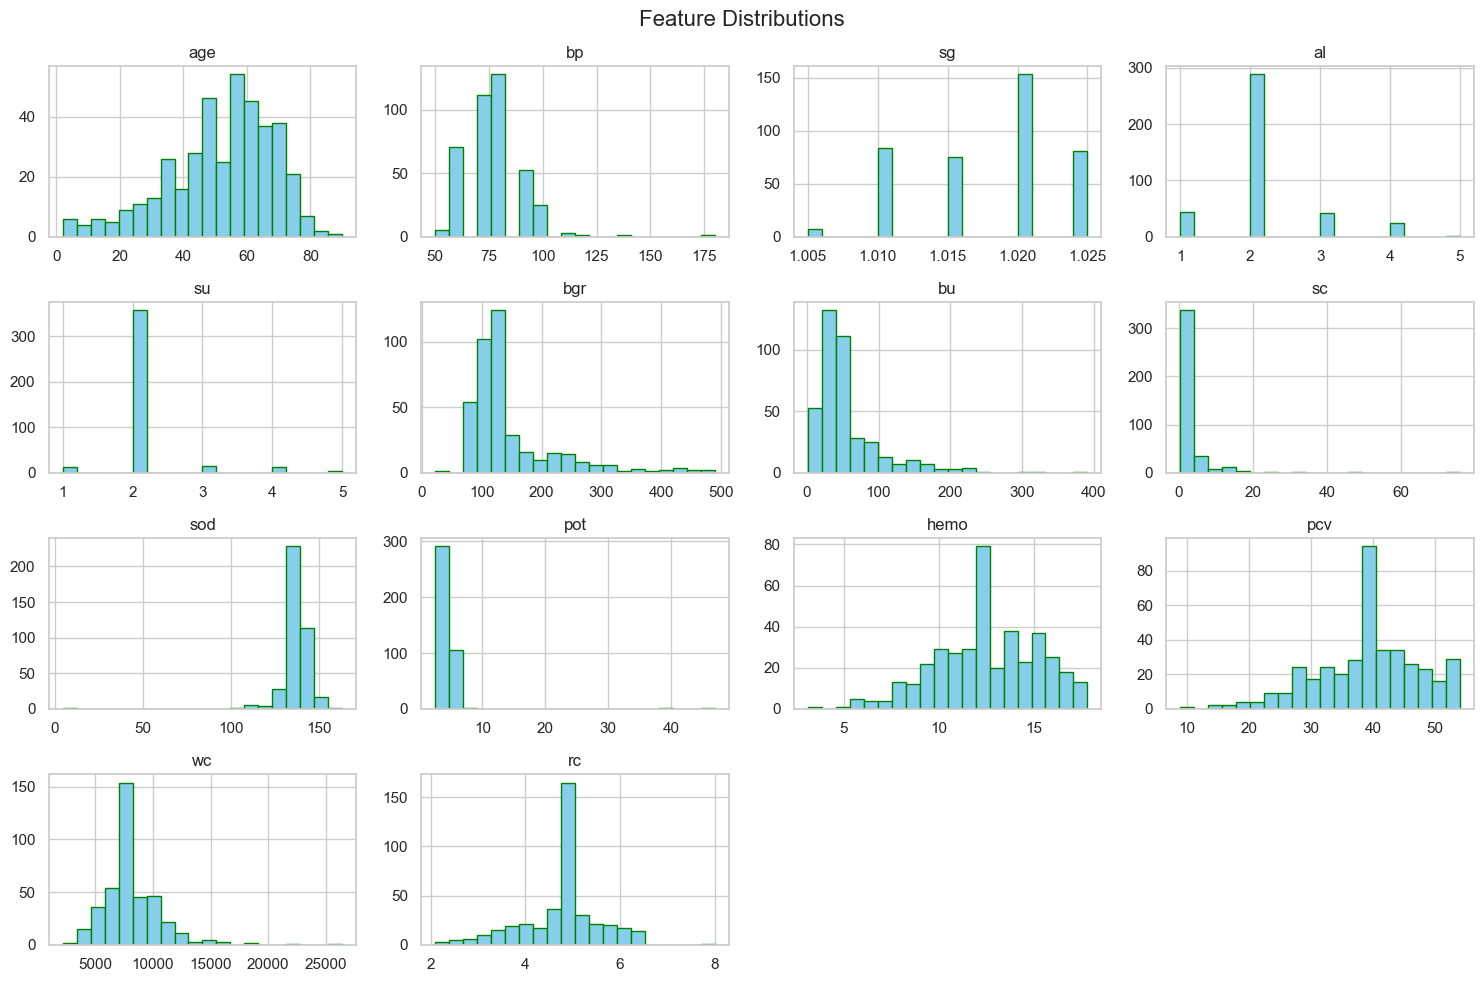

In [46]:
# Set a consistent style
sns.set(style="whitegrid")

# Select numerical columns (14)
numerical_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

# Histogram for distributions
plt.figure(figsize=(15, 10))
df[numerical_cols].hist(bins=20, color='skyblue', edgecolor='green', figsize=(15, 10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

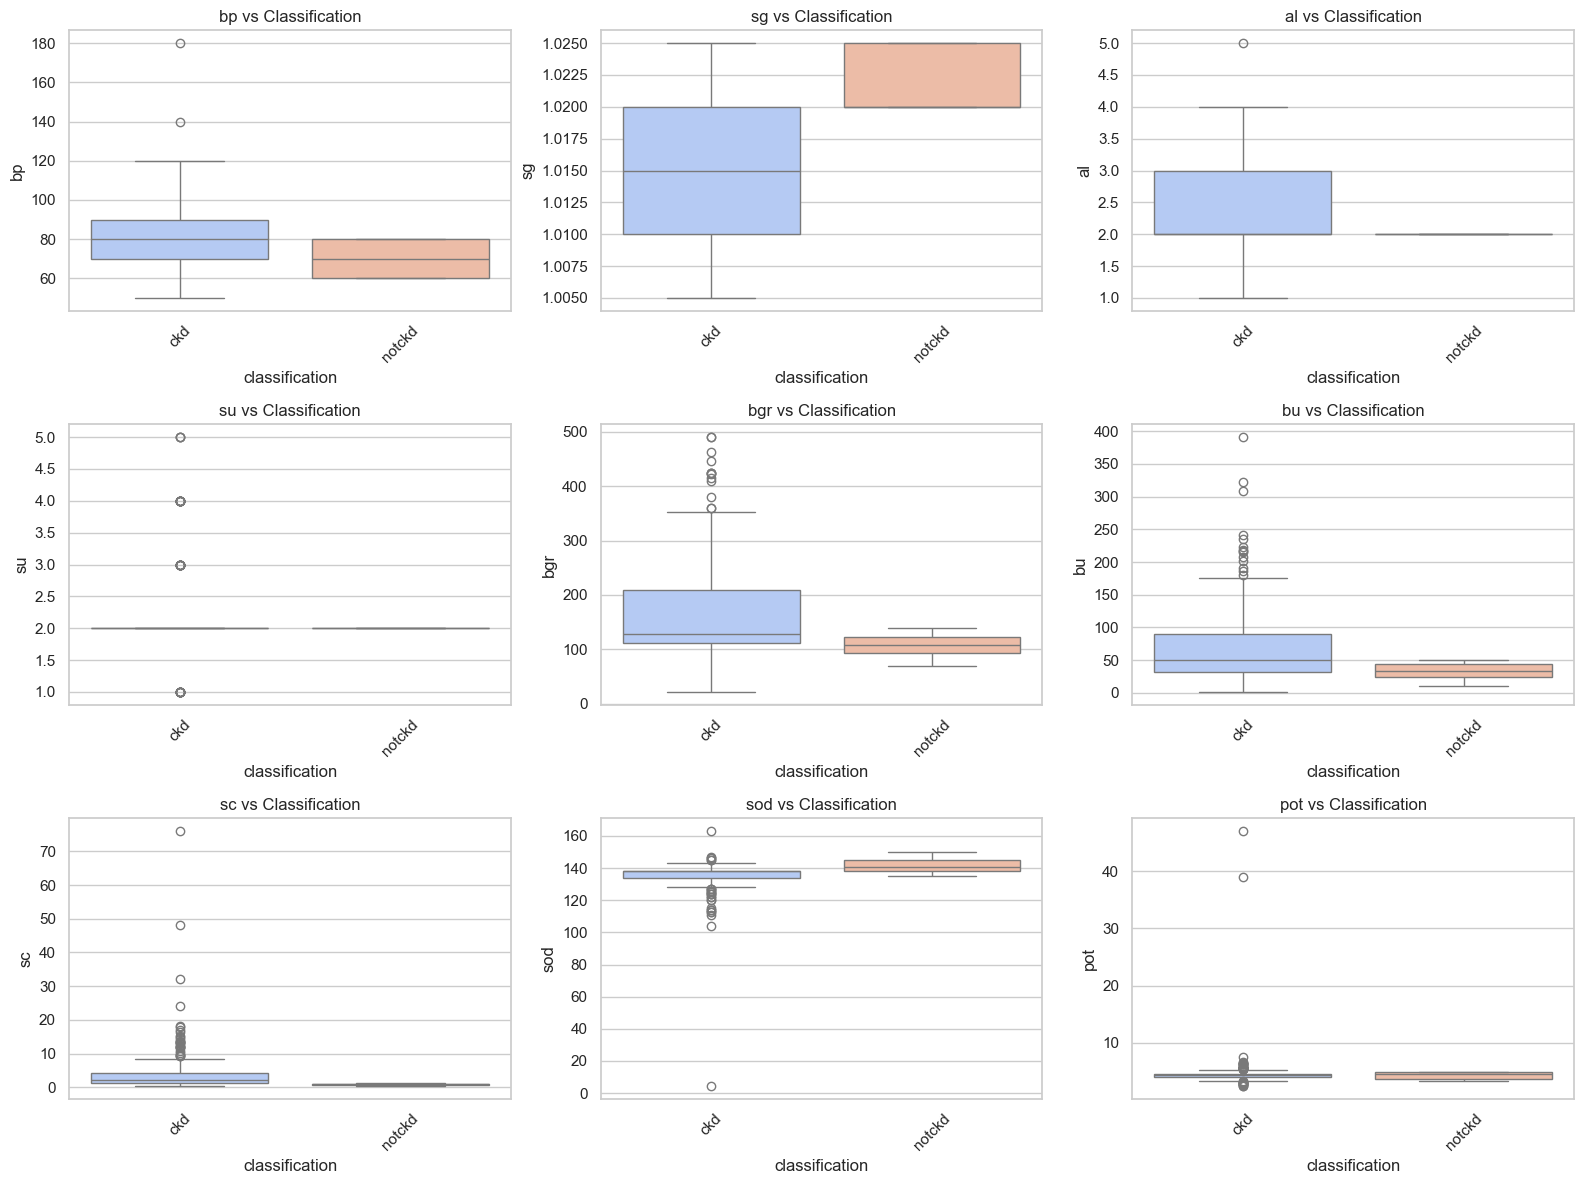

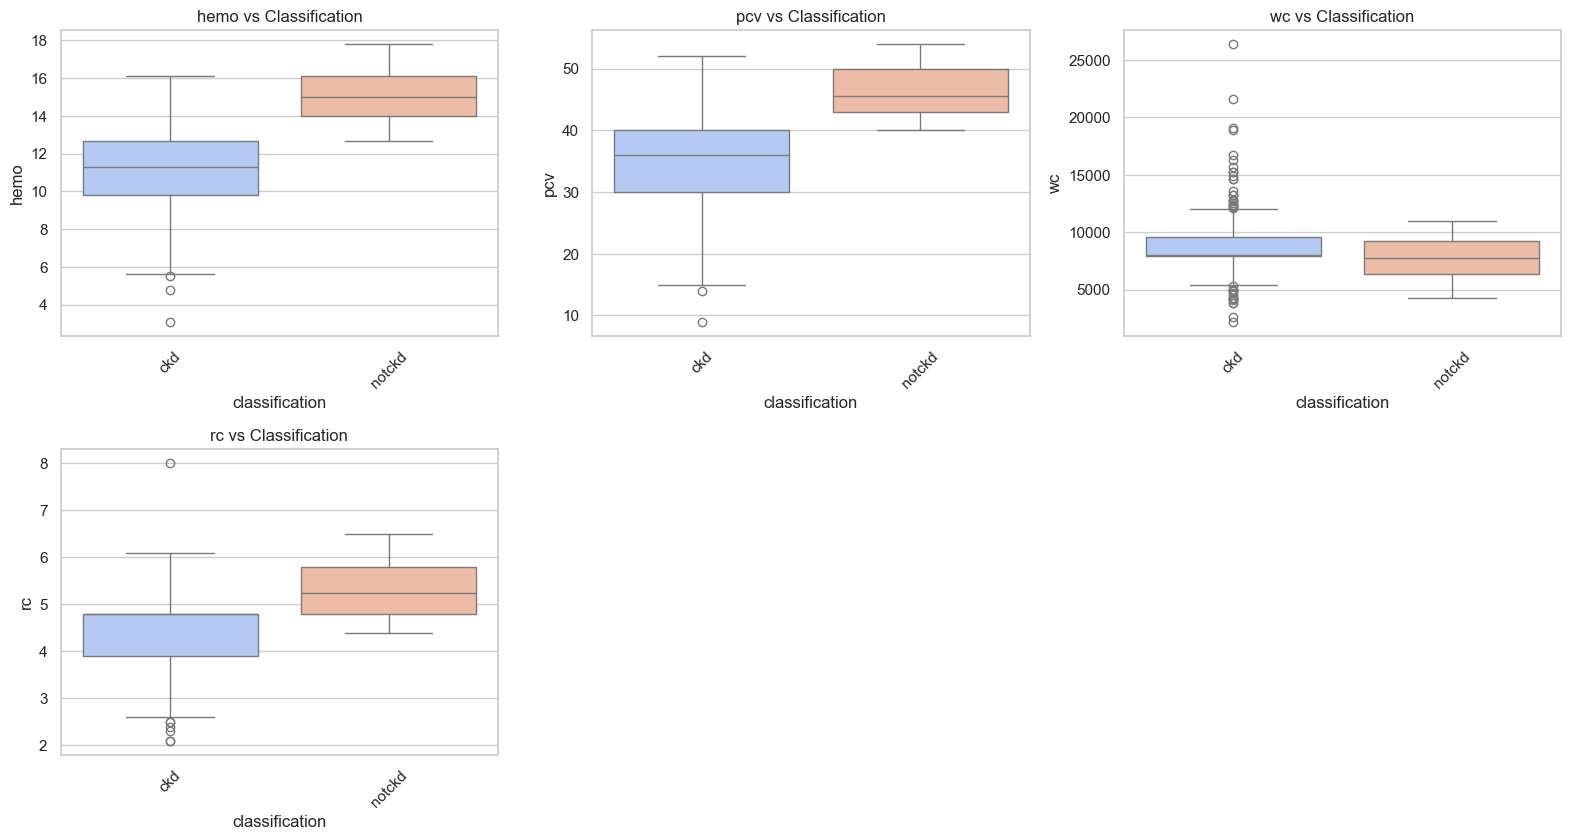

In [48]:
# Select only numerical columns
columns = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = len(columns)
plots_per_figure = 9

for i in range(1, num_cols, plots_per_figure):
    plt.figure(figsize=(16, 12))
    for idx, col in enumerate(columns[i:i + plots_per_figure], 1):
        plt.subplot(3, 3, idx)
        sns.boxplot(x='classification', y=col, data=df, palette='coolwarm')
        plt.title(f'{col} vs Classification')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


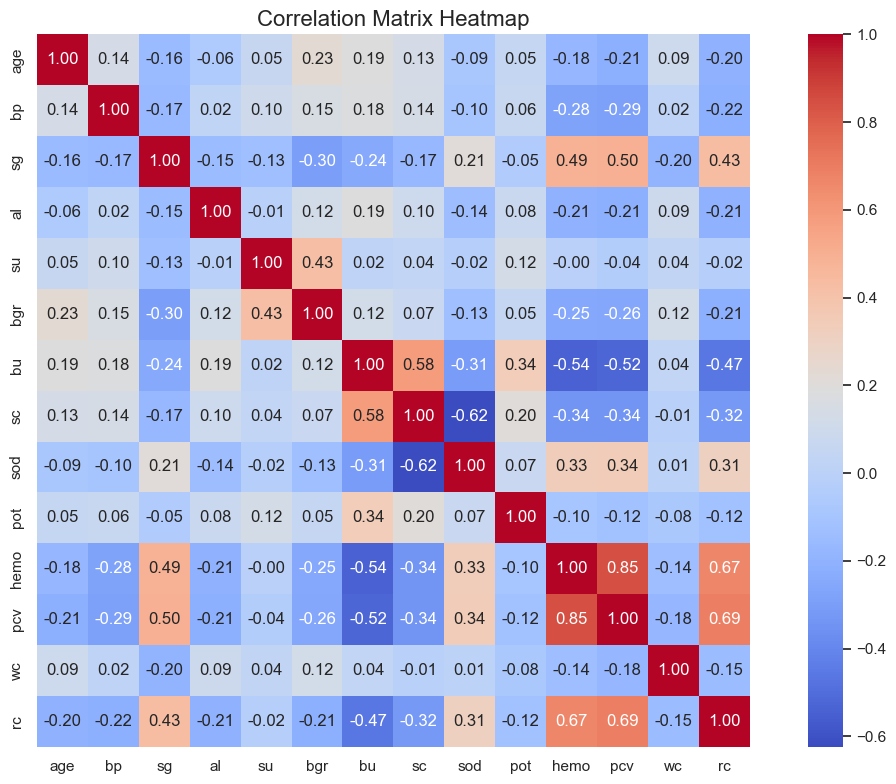

In [52]:
# Compute correlation matrix Heat Map for numeric columns only
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

In [55]:
# Define feature sets
numerical_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
target_col = 'classification'

# Encode target
df[target_col] = df[target_col].map({'ckd': 1, 'notckd': 0})


### PREPROCESSING

In [58]:
# Preprocessing For logistic Regression
# One-Hot + Scaling pipeline
preprocessor_lr = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

logreg_pipeline = Pipeline([
    ('preprocess', preprocessor_lr),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [60]:
# Preprocessing For XGBoost

# Dictionary to store encoders and their mappings
label_maps = {}
# Label Encode categoricals manually
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Standardize numeric values
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Split data
X = df[numerical_cols + categorical_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [62]:
for col, mapping in label_maps.items():
    print(f"{col}: {mapping}")


rbc: {'abnormal': 0, 'normal': 1}
pc: {'abnormal': 0, 'normal': 1}
pcc: {'notpresent': 0, 'present': 1}
ba: {'notpresent': 0, 'present': 1}
htn: {'no': 0, 'yes': 1}
dm: {'no': 0, 'yes': 1}
cad: {'no': 0, 'yes': 1}
appet: {'good': 0, 'poor': 1}
pe: {'no': 0, 'yes': 1}
ane: {'no': 0, 'yes': 1}


In [65]:
# For logistic regression
# One-Hot Encoding + Scaling
preprocessor_lr = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

# Full pipeline
logreg_pipeline = Pipeline([
    ('prep', preprocessor_lr),
    ('clf', LogisticRegression(max_iter=1000))
])

# Split original df (before label encoding)
X = df.drop('classification', axis=1)
y = df['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
logreg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bp', 'sg', 'al',
                                                   'su', 'bgr', 'bu', 'sc',
                                                   'sod', 'pot', 'hemo', 'pcv',
                                                   'wc', 'rc']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['rbc', 'pc', 'pcc', 'ba',
                                                   'htn', 'dm', 'cad', 'appet',
                                                   'pe', 'ane'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [68]:
# Divide features to training data and testing data

print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in testing set:\n{y_test.value_counts(normalize=True)}")

Training data: (320, 24), Testing data: (80, 24)
Class distribution in training set:
classification
1    0.61875
0    0.38125
Name: proportion, dtype: float64
Class distribution in testing set:
classification
1    0.65
0    0.35
Name: proportion, dtype: float64


In [70]:
# Let's check the shape of each split to understand the sizes
print("X_train shape:", X_train.shape)   # Features for training (80% of rows)
print("X_test shape:", X_test.shape)     # Features for testing (20% of rows)
print("y_train shape:", y_train.shape)   # Labels for training set
print("y_test shape:", y_test.shape)     # Labels for test set

X_train shape: (320, 24)
X_test shape: (80, 24)
y_train shape: (320,)
y_test shape: (80,)


### MODEL TRAINING

In [106]:
# Having already defined:
# X_train, X_test, y_train, y_test
# and built the logistic regression pipeline `logreg_pipeline`

# Train the Logistic Regression model
model = logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_pipeline.predict(X_test)

# Compute accuracy and convert to percentage
acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {acc:.2f}%")    

# Print full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# precision, recall and f1-score in a neat DataFrame (percentages):
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df   = pd.DataFrame(report_dict).T

# Multiply by 100 and round
percent_df = report_df[['precision','recall','f1-score']] * 100
print("\nMetrics (in %):\n", percent_df.round(2))



Accuracy: 98.75%

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80


Confusion Matrix:
 [[28  0]
 [ 1 51]]

Metrics (in %):
               precision  recall  f1-score
0                 96.55  100.00     98.25
1                100.00   98.08     99.03
accuracy          98.75   98.75     98.75
macro avg         98.28   99.04     98.64
weighted avg      98.79   98.75     98.75


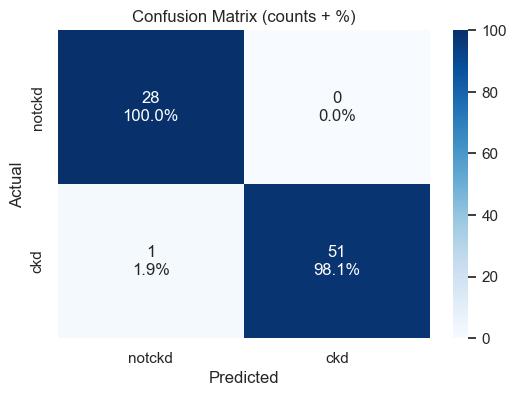

In [108]:
# Compute raw confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Convert counts to percentages
conf_mat_pct = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100
labels = np.array([["{0}\n{1:.1f}%".format(count, pct) 
                    for count, pct in zip(row_counts, row_pcts)] 
                   for row_counts, row_pcts in zip(conf_mat, conf_mat_pct)])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_pct, annot=labels, fmt='', cmap='Blues',
            xticklabels=['notckd', 'ckd'], yticklabels=['notckd', 'ckd'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (counts + %)')
plt.show()


In [122]:
# Without the pipeline
# Train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)  # max_iter ensures convergence
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9875

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80


Confusion Matrix:
 [[28  0]
 [ 1 51]]


In [120]:
# Select a specific test sample by position
row_index = 24  
sample = X_test.iloc[row_index].values.reshape(1, -1)

# Make predictions
predicted_label = model.predict(sample)[0]
predicted_prob = model.predict_proba(sample)[0][1] * 100  # convert to percentage

# Get the actual label
actual_label = y_test.iloc[row_index]

# Display results
print(f"Row {row_index} prediction: {predicted_label} "
      f"(probability of 'ckd' = {predicted_prob:.2f}%)")
print(f"Actual label: {actual_label}")


Row 24 prediction: 0 (probability of 'ckd' = 39.01%)
Actual label: 1


In [125]:
"""
while True:
    user_input = input("Enter a test row number to predict (or 'q' to quit): ")
    
    if user_input.lower() == 'q':
        print("Exiting...")
        break
    
    if not user_input.isdigit():
        print("Please enter a valid integer row number or 'q' to quit.")
        continue
    
    row_index = int(user_input)
    
    if row_index < 0 or row_index >= len(X_test):
        print(f"Please enter a number between 0 and {len(X_test) - 1}")
        continue
    
    # Use .iloc for row selection
    sample = X_test.iloc[row_index].values.reshape(1, -1)
    predicted_label = model.predict(sample)[0]
    predicted_prob = model.predict_proba(sample)[0][1]
    actual_label = y_test.iloc[row_index]
    
    # Adjust for your labels ('ckd' and 'notckd')
    print(f"Row {row_index} prediction: {predicted_label} (probability of 'ckd' = {predicted_prob:.4f})")
    print(f"Actual label: {actual_label}\n")
"""

'\nwhile True:\n    user_input = input("Enter a test row number to predict (or \'q\' to quit): ")\n    \n    if user_input.lower() == \'q\':\n        print("Exiting...")\n        break\n    \n    if not user_input.isdigit():\n        print("Please enter a valid integer row number or \'q\' to quit.")\n        continue\n    \n    row_index = int(user_input)\n    \n    if row_index < 0 or row_index >= len(X_test):\n        print(f"Please enter a number between 0 and {len(X_test) - 1}")\n        continue\n    \n    # Use .iloc for row selection\n    sample = X_test.iloc[row_index].values.reshape(1, -1)\n    predicted_label = model.predict(sample)[0]\n    predicted_prob = model.predict_proba(sample)[0][1]\n    actual_label = y_test.iloc[row_index]\n    \n    # Adjust for your labels (\'ckd\' and \'notckd\')\n    print(f"Row {row_index} prediction: {predicted_label} (probability of \'ckd\' = {predicted_prob:.4f})")\n    print(f"Actual label: {actual_label}\n")\n'

In [128]:
# USING XGBoost
# Encode labels if needed
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc  = label_encoder.transform(y_test)

# Train the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train_enc)

# Predict
xgb_pred = xgb_model.predict(X_test)

# Print metrics
acc_xgb = accuracy_score(y_test_enc, xgb_pred) * 100
print("\n⚡ XGBoost")
print(f"Accuracy: {acc_xgb:.2f}%")
print("Classification Report:\n", classification_report(y_test_enc, xgb_pred))

# Sample verification
xgb_pred_decoded = label_encoder.inverse_transform(xgb_pred)
y_test_decoded   = label_encoder.inverse_transform(y_test_enc)

print("\nSample Predictions:")
for i in range(5):
    print(f"Actual: {y_test_decoded[i]}, Predicted: {xgb_pred_decoded[i]}")



⚡ XGBoost
Accuracy: 98.75%
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80


Sample Predictions:
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1


In [131]:
"""
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test_enc, xgb_proba)
auc_xgb = auc(fpr, tpr) * 100  # in percentage

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, 
         label=f'XGBoost (AUC = {auc_xgb:.2f}%)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', 
         label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
"""

"\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import roc_curve, auc\n\n# Predict probabilities\nxgb_proba = xgb_model.predict_proba(X_test)[:, 1]\nfpr, tpr, _ = roc_curve(y_test_enc, xgb_proba)\nauc_xgb = auc(fpr, tpr) * 100  # in percentage\n\nplt.figure(figsize=(8, 6))\nplt.plot(fpr, tpr, color='green', lw=2, \n         label=f'XGBoost (AUC = {auc_xgb:.2f}%)')\nplt.plot([0, 1], [0, 1], color='red', linestyle='--', \n         label='Random Guess')\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('ROC Curve for XGBoost')\nplt.legend(loc='lower right')\nplt.grid(alpha=0.3)\nplt.tight_layout()\nplt.show()\n"

In [134]:
"""
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

# Logistic Regression
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train, y_train_enc)
log_proba = log_model.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test_enc, log_proba)
auc_log = auc(fpr_log, tpr_log) * 100

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train_enc)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_enc, xgb_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb) * 100

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, 
         label=f'Logistic Regression (AUC = {auc_log:.2f}%)')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, 
         label=f'XGBoost (AUC = {auc_xgb:.2f}%)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', 
         label='Random Guess')

plt.fill_between(fpr_log, tpr_log, alpha=0.2, color='blue')
plt.fill_between(fpr_xgb, tpr_xgb, alpha=0.2, color='green')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with AUC (%) Shading')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
"""

"\nimport matplotlib.pyplot as plt\nfrom sklearn.linear_model import LogisticRegression\nfrom xgboost import XGBClassifier\nfrom sklearn.metrics import roc_curve, auc\n\n# Logistic Regression\nlog_model = LogisticRegression(random_state=42, max_iter=1000)\nlog_model.fit(X_train, y_train_enc)\nlog_proba = log_model.predict_proba(X_test)[:, 1]\nfpr_log, tpr_log, _ = roc_curve(y_test_enc, log_proba)\nauc_log = auc(fpr_log, tpr_log) * 100\n\n# XGBoost\nxgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)\nxgb_model.fit(X_train, y_train_enc)\nxgb_proba = xgb_model.predict_proba(X_test)[:, 1]\nfpr_xgb, tpr_xgb, _ = roc_curve(y_test_enc, xgb_proba)\nauc_xgb = auc(fpr_xgb, tpr_xgb) * 100\n\nplt.figure(figsize=(10, 6))\nplt.plot(fpr_log, tpr_log, color='blue', lw=2, \n         label=f'Logistic Regression (AUC = {auc_log:.2f}%)')\nplt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, \n         label=f'XGBoost (AUC = {auc_xgb:.2f}%)')\nplt.plot([0, 1], [0, 1], col

### VISUALIZATION WITH CURVE

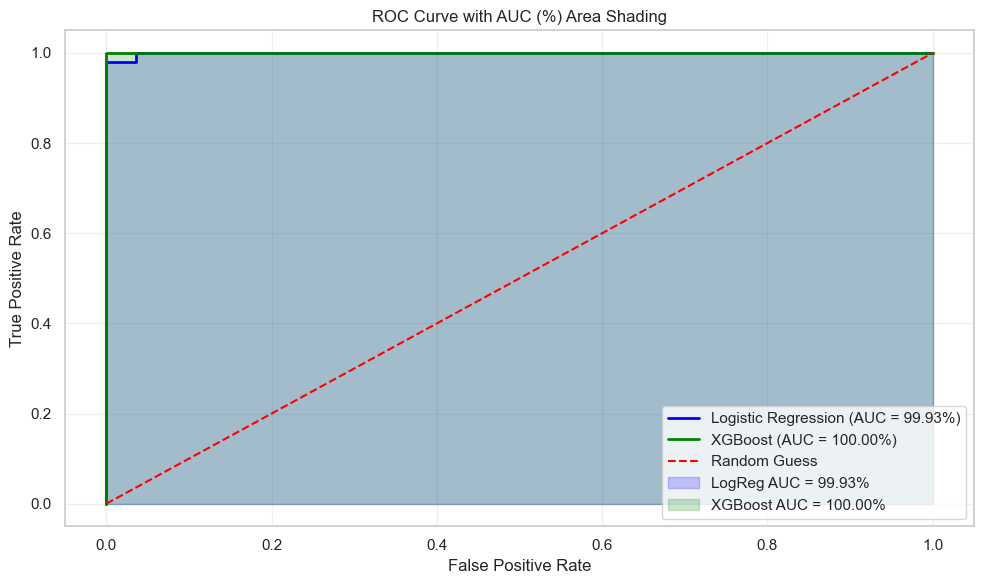

In [146]:
# Logistic Regression
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train, y_train_enc)
log_proba = log_model.predict_proba(X_test)[:, 1]

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train_enc)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# ROC Curve and AUC (as %)
fpr_log, tpr_log, _ = roc_curve(y_test_enc, log_proba)
auc_log = auc(fpr_log, tpr_log) * 100

fpr_xgb, tpr_xgb, _ = roc_curve(y_test_enc, xgb_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb) * 100

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2,
         label=f'Logistic Regression (AUC = {auc_log:.2f}%)')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2,
         label=f'XGBoost (AUC = {auc_xgb:.2f}%)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.fill_between(fpr_log, tpr_log, alpha=0.2, color='blue',
                 label=f'LogReg AUC = {auc_log:.2f}%')
plt.fill_between(fpr_xgb, tpr_xgb, alpha=0.2, color='green',
                 label=f'XGBoost AUC = {auc_xgb:.2f}%')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC (%) Area Shading')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [149]:
import joblib

# Saving the trained XGBoost model
joblib.dump(xgb_model, "xgb_kidney_disease_model.pkl")
joblib.dump(X_train.columns.tolist(), "model_columns.pkl")

print("Model saved as xgb_kidney_disease_model.pkl")


Model saved as xgb_kidney_disease_model.pkl
